In [1]:
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as math
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns

In [2]:
#Loads the complete data set and narrows down the attributes we want to consider
completeDataSet = pd.read_csv('US_Accidents_Dec19.csv')
dataSetTemp=completeDataSet[['Start_Time','Severity','Description','City','State','Temperature(F)','Weather_Condition','Amenity','Crossing','Junction','Railway','Station','Stop','Traffic_Signal','Bump','Give_Way','No_Exit','Roundabout','Traffic_Calming','Turning_Loop','Sunrise_Sunset']]

In [3]:
#Drops all accidents not occuring in CA
dataSet = dataSetTemp.copy()
dataSet=dataSet.drop([i for i in range(0, len(dataSet)) if (dataSet['State'][i] != 'CA')])
dataSet
dataSet.describe()

,Severity,Temperature(F)
count,663204.000000,648079.000000
mean,2.337331,65.681507
std,0.493503,12.472955
min,1.000000,-29.900000
25%,2.000000,57.000000
50%,2.000000,64.400000
75%,3.000000,73.400000
max,4.000000,127.400000


In [4]:
dataSet['Temperature'] = pd.cut(dataSet['Temperature(F)'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                              labels=['0-20', '20-30', '30-40', '40-50','50-60','60-70','70-80', '80-90','>90'])
dataSet  = dataSet.drop('Temperature(F)',axis = 1)

In [5]:
#drop the state column since it's unnecessary at this point
del dataSet['State']
#Makes sure that the severity levels are converted to strings
dataSet['Severity'] = [str(i) for i in dataSet['Severity']]
dataSet['Month']=[i.split("-")[1] for i in dataSet['Start_Time']]
del dataSet['Start_Time']



dataSet.loc[dataSet['Description'].str.contains('delay|delayed',case=False), 'Description'] = 'delay'
dataSet.loc[dataSet['Description'].str.contains('blocked|block',case=False), 'Description'] = 'blocked'
dataSet.loc[~dataSet['Description'].str.contains('delay|blocked|delayed|block',case=False), 'Description'] = 'No delay or block'





dataSet["Weather_Condition"].fillna("No Value", inplace = True) 
dataSet.loc[dataSet['Weather_Condition'].str.contains('Snow',case=False), 'Weather_Condition'] = 'Snow'
dataSet.loc[dataSet['Weather_Condition'].str.contains('Fair',case=False), 'Weather_Condition'] = 'Clear'
dataSet.loc[dataSet['Weather_Condition'].str.contains('Rain',case=False), 'Weather_Condition'] = 'Rain'
dataSet.loc[dataSet['Weather_Condition'].str.contains('Fog',case=False), 'Weather_Condition'] = 'Fog'
dataSet.loc[dataSet['Weather_Condition'].str.contains('Haze',case=False), 'Weather_Condition'] = 'Fog'
dataSet.loc[dataSet['Weather_Condition'].str.contains('Cloud',case=False), 'Weather_Condition'] = 'Cloudy'
dataSet.loc[dataSet['Weather_Condition'].str.contains('Overcast',case=False), 'Weather_Condition'] = 'Cloudy'
dataSet.loc[~dataSet['Weather_Condition'].str.contains('Overcast|Cloud|Haze|Fog|Rain|Clear|Snow',case=False), 'Weather_Condition'] = 'Other'


dataSet

,Severity,Description,City,Weather_Condition,Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Bump,Give_Way,No_Exit,Roundabout,Traffic_Calming,Turning_Loop,Sunrise_Sunset,Temperature,Month
728,3,blocked,Vallejo,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,70-80,06
729,3,No delay or block,Hayward,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,70-80,06
730,2,blocked,Walnut Creek,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,80-90,06
731,3,blocked,Cupertino,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,70-80,06
732,2,blocked,San Jose,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,70-80,06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974330,2,No delay or block,Riverside,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,80-90,08
2974331,2,No delay or block,San Diego,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,60-70,08
2974332,2,No delay or block,Orange,Cloudy,False,False,True,False,False,False,False,False,False,False,False,False,False,Day,70-80,08
2974333,2,No delay or block,Culver City,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,70-80,08


In [6]:
#Replaces true/false values in some attributes with a string labeling
dataSet.Bump = dataSet.Bump.replace({False:'Bump_False',True:'Bump_True'})
dataSet.Amenity = dataSet.Amenity.replace({False:'Amenity_False',True:'Amenity_True'})
dataSet.Crossing = dataSet.Crossing.replace({False:'Crossing_False',True:'Crossing_True'})
dataSet.Give_Way = dataSet.Give_Way.replace({False:'Give_Way_False',True:'Give_Way_True'})
dataSet.Junction = dataSet.Junction.replace({False:'Junction_False',True:'Junction_True'})
dataSet.No_Exit = dataSet.No_Exit.replace({False:'No_Exit_False',True:'No_Exit_True'})
dataSet.Railway = dataSet.Railway.replace({False:'Railway_False',True:'Railway_True'})
dataSet.Roundabout = dataSet.Roundabout.replace({False:'Roundabout_False',True:'Roundabout_True'})
dataSet.Station = dataSet.Station.replace({False:'Station_False',True:'Station_True'})
dataSet.Stop = dataSet.Stop.replace({False:'Stop_False',True:'Stop_True'})
dataSet.Traffic_Calming = dataSet.Traffic_Calming.replace({False:'Traffic_Calming_False',True:'Traffic_Calming_True'})
dataSet.Traffic_Signal = dataSet.Traffic_Signal.replace({False:'Traffic_Signal_False',True:'Traffic_Signal_True'})
dataSet.Turning_Loop = dataSet.Turning_Loop.replace({False:'Turning_Loop_False',True:'Turning_Loop_True'})


In [7]:
#Ensures we have no nan values
dataSet = dataSet.dropna()
dataSet.isnull().sum()*100/dataSet.shape[0]

Severity             0.0
Description          0.0
City                 0.0
Weather_Condition    0.0
Amenity              0.0
Crossing             0.0
Junction             0.0
Railway              0.0
Station              0.0
Stop                 0.0
Traffic_Signal       0.0
Bump                 0.0
Give_Way             0.0
No_Exit              0.0
Roundabout           0.0
Traffic_Calming      0.0
Turning_Loop         0.0
Sunrise_Sunset       0.0
Temperature          0.0
Month                0.0
dtype: float64

In [8]:
dataSetCopy = dataSet.copy()

In [9]:
dataSet.describe()

,Severity,Description,City,Weather_Condition,Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Bump,Give_Way,No_Exit,Roundabout,Traffic_Calming,Turning_Loop,Sunrise_Sunset,Temperature,Month
count,645067,645067,645067,645067,645067,645067,645067,645067,645067,645067,645067,645067,645067,645067,645067,645067,645067,645067,645067,645067
unique,4,3,1134,6,2,2,2,2,2,2,2,2,2,2,2,2,1,2,9,12
top,2,No delay or block,Los Angeles,Clear,Amenity_False,Crossing_False,Junction_False,Railway_False,Station_False,Stop_False,Traffic_Signal_False,Bump_False,Give_Way_False,No_Exit_False,Roundabout_False,Traffic_Calming_False,Turning_Loop_False,Day,60-70,10
freq,433278,403272,65428,353112,640898,626977,558946,638216,632578,634583,596314,644961,644616,644818,645049,644911,645067,438169,220177,75233


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2765705.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 2765705.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 2765705.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 107907, cost: 2517185.0
Run 1, iteration: 2/100, moves: 27555, cost: 2517185.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 36853, cost: 2524313.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 116782, cost: 2505898.0
Best run was number 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/1

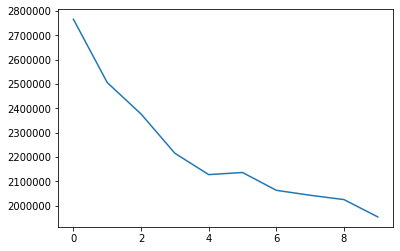

In [592]:
#determines the optimal number of k clusters from 1 to 10 clusters
#plots the elbow-test graph based on the cost of running k-modes for each of the k number of clusters
cost = []
for num_clusters in list(range(1,11)):
    km = KModes(n_clusters=num_clusters, init='Huang', n_init=3, verbose=1)
    km.fit_predict(dataSetCopy)
    cost.append(km.cost_)
plt.plot(cost)

In [10]:
#Runs k-modes with 5 clusters
km = KModes(n_clusters=5, init='Huang', n_init=3, verbose=1)
clusters = km.fit_predict(dataSetCopy)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 124766, cost: 2195039.0
Run 1, iteration: 2/100, moves: 8223, cost: 2195039.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 206632, cost: 2096230.0
Run 2, iteration: 2/100, moves: 49396, cost: 2096230.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 30578, cost: 2147464.0
Best run was number 2


In [11]:
print(clusters)



[3 1 1 ... 1 1 1]


In [12]:
#moves each accident to its cluster
cluster0 = dataSet.copy()
cluster0=cluster0.drop(cluster0.index[i] for i in range(0, len(clusters)) if clusters[i] != 0)
cl0=cluster0.copy()

cluster1 = dataSet.copy()
cluster1=cluster1.drop(cluster1.index[i] for i in range(0, len(clusters)) if clusters[i] != 1)
cl1=cluster1.copy()

cluster2 = dataSet.copy()
cluster2=cluster2.drop(cluster2.index[i] for i in range(0, len(clusters)) if clusters[i] != 2)
cl2=cluster2.copy()

cluster3 = dataSet.copy()
cluster3=cluster3.drop(cluster3.index[i] for i in range(0, len(clusters)) if clusters[i] != 3)
cl3=cluster3.copy()

cluster4 = dataSet.copy()
cluster4=cluster4.drop(cluster4.index[i] for i in range(0, len(clusters)) if clusters[i] != 4)
cl4=cluster4.copy()


In [13]:
cl0["cluster_predicted"] = 0
cl1["cluster_predicted"] = 1
cl2["cluster_predicted"] = 2
cl3["cluster_predicted"] = 3
cl4["cluster_predicted"] = 4


In [14]:
frames = [cl0,cl1,cl2,cl3,cl4]

In [15]:
combinedClusters = pd.concat(frames)

In [16]:
combinedClusters.describe()

,cluster_predicted
count,645067.000000
mean,1.446360
std,1.264657
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


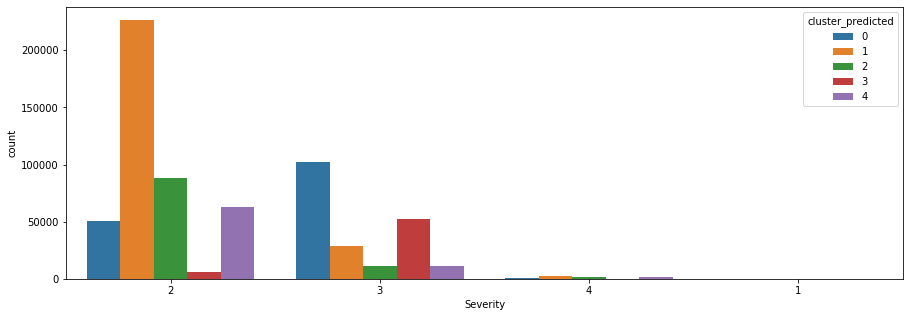

In [17]:
#Plotting Severity of each cluster
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedClusters['Severity'],order=combinedClusters['Severity'].value_counts().index,hue=combinedClusters['cluster_predicted'])
plt.show()

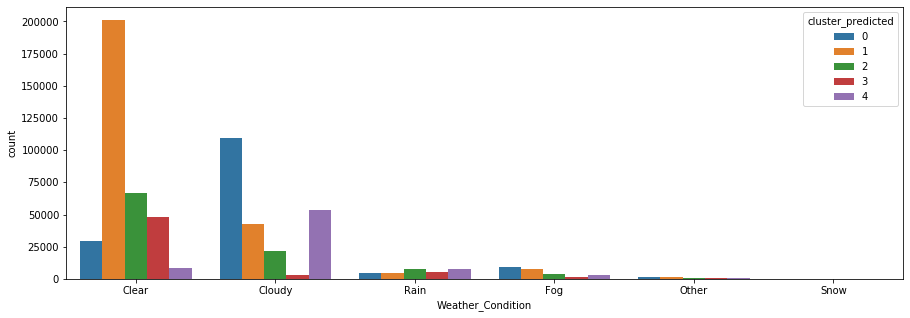

In [18]:
#Plotting Weather Conditions of each cluster
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedClusters['Weather_Condition'],order=combinedClusters['Weather_Condition'].value_counts().index,hue=combinedClusters['cluster_predicted'])
plt.show()

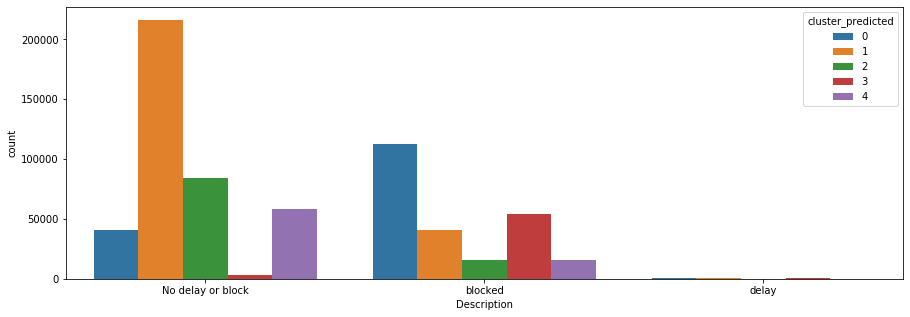

In [19]:
#Plotting Descriptions of each cluster
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedClusters['Description'],order=combinedClusters['Description'].value_counts().index,hue=combinedClusters['cluster_predicted'])
plt.show()

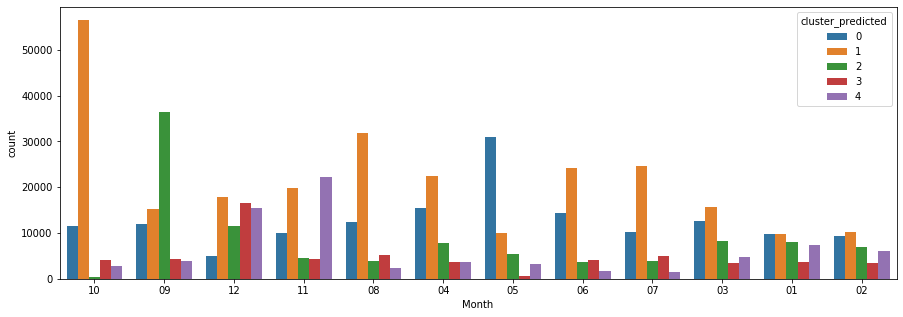

In [20]:
#Plotting Months of each cluster
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedClusters['Month'],order=combinedClusters['Month'].value_counts().index,hue=combinedClusters['cluster_predicted'])
plt.show()

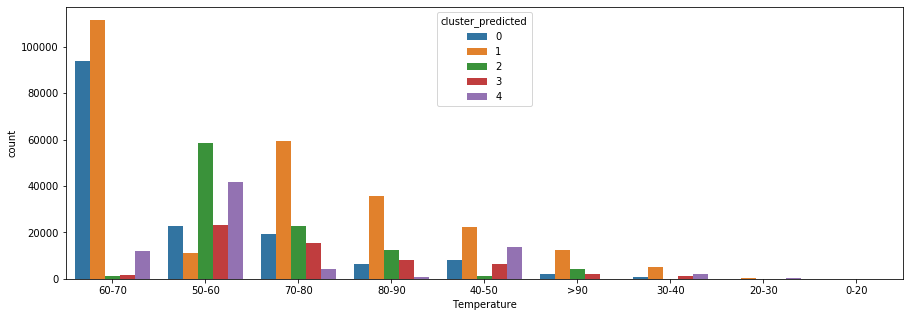

In [21]:
#Plotting Temperatures of each cluster
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedClusters['Temperature'],order=combinedClusters['Temperature'].value_counts().index,hue=combinedClusters['cluster_predicted'])
plt.show()

In [22]:
#describing each cluster
cluster0.describe()


,Severity,Description,City,Weather_Condition,Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Bump,Give_Way,No_Exit,Roundabout,Traffic_Calming,Turning_Loop,Sunrise_Sunset,Temperature,Month
count,153553,153553,153553,153553,153553,153553,153553,153553,153553,153553,153553,153553,153553,153553,153553,153553,153553,153553,153553,153553
unique,4,3,880,6,2,2,2,2,2,2,2,2,2,2,1,2,1,2,9,12
top,3,blocked,Los Angeles,Cloudy,Amenity_False,Crossing_False,Junction_False,Railway_False,Station_False,Stop_False,Traffic_Signal_False,Bump_False,Give_Way_False,No_Exit_False,Roundabout_False,Traffic_Calming_False,Turning_Loop_False,Day,60-70,05
freq,102403,112329,21320,109611,152768,150881,132552,151850,151020,152625,146184,153536,153494,153471,153553,153532,153553,119607,93876,31045


In [23]:
cluster1.describe()

,Severity,Description,City,Weather_Condition,Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Bump,Give_Way,No_Exit,Roundabout,Traffic_Calming,Turning_Loop,Sunrise_Sunset,Temperature,Month
count,257851,257851,257851,257851,257851,257851,257851,257851,257851,257851,257851,257851,257851,257851,257851,257851,257851,257851,257851,257851
unique,4,3,1101,6,2,2,2,2,2,2,2,2,2,2,2,2,1,2,9,12
top,2,No delay or block,Sacramento,Clear,Amenity_False,Crossing_False,Junction_False,Railway_False,Station_False,Stop_False,Traffic_Signal_False,Bump_False,Give_Way_False,No_Exit_False,Roundabout_False,Traffic_Calming_False,Turning_Loop_False,Day,60-70,10
freq,226515,216270,19122,201055,256166,249310,224079,255395,252746,252356,234801,257802,257637,257762,257841,257782,257851,199203,111560,56510


In [24]:
cluster2.describe()

,Severity,Description,City,Weather_Condition,Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Bump,Give_Way,No_Exit,Roundabout,Traffic_Calming,Turning_Loop,Sunrise_Sunset,Temperature,Month
count,100606,100606,100606,100606,100606,100606,100606,100606,100606,100606,100606,100606,100606,100606,100606,100606,100606,100606,100606,100606
unique,4,3,1030,6,2,2,2,2,2,2,2,2,2,2,2,2,1,2,8,12
top,2,No delay or block,Los Angeles,Clear,Amenity_False,Crossing_False,Junction_False,Railway_False,Station_False,Stop_False,Traffic_Signal_False,Bump_False,Give_Way_False,No_Exit_False,Roundabout_False,Traffic_Calming_False,Turning_Loop_False,Day,50-60,09
freq,88124,84359,19322,66586,99772,97067,87208,99465,98187,98274,90828,100588,100514,100575,100601,100572,100606,78529,58537,36307


In [25]:
cluster3.describe()

,Severity,Description,City,Weather_Condition,Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Bump,Give_Way,No_Exit,Roundabout,Traffic_Calming,Turning_Loop,Sunrise_Sunset,Temperature,Month
count,58292,58292,58292,58292,58292,58292,58292,58292,58292,58292,58292,58292,58292,58292,58292,58292,58292,58292,58292,58292
unique,4,3,646,6,2,2,2,2,2,2,2,2,2,2,1,2,1,2,9,12
top,3,blocked,Los Angeles,Clear,Amenity_False,Crossing_False,Junction_False,Railway_False,Station_False,Stop_False,Traffic_Signal_False,Bump_False,Give_Way_False,No_Exit_False,Roundabout_False,Traffic_Calming_False,Turning_Loop_False,Day,50-60,12
freq,52395,54432,7686,47744,58035,57598,50355,57527,57359,58070,56236,58285,58282,58272,58292,58282,58292,36893,22981,16528


In [26]:
cluster4.describe()

,Severity,Description,City,Weather_Condition,Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Bump,Give_Way,No_Exit,Roundabout,Traffic_Calming,Turning_Loop,Sunrise_Sunset,Temperature,Month
count,74765,74765,74765,74765,74765,74765,74765,74765,74765,74765,74765,74765,74765,74765,74765,74765,74765,74765,74765,74765
unique,4,3,1017,6,2,2,2,2,2,2,2,2,2,2,2,2,1,2,9,12
top,2,No delay or block,Los Angeles,Cloudy,Amenity_False,Crossing_False,Junction_False,Railway_False,Station_False,Stop_False,Traffic_Signal_False,Bump_False,Give_Way_False,No_Exit_False,Roundabout_False,Traffic_Calming_False,Turning_Loop_False,Night,50-60,11
freq,62596,58525,6998,53672,74157,72121,64752,73979,73266,73258,68265,74750,74689,74738,74762,74743,74765,70828,41578,22130


In [27]:
#Converts the clusters from dataframes to list representations and preprocesses them for the apriori algorithm

cluster0Apriori = [None] * len(cluster0)

for i in range(0, len(cluster0Apriori)):
    cluster0Apriori[i] = [columnData[cluster0.index[i]] for (columnName, columnData) in cluster0.iteritems()]
    cluster0Apriori[i][0] = "Severity_"+cluster0Apriori[i][0]
    if 'Amenity_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Amenity_False')
    if 'Crossing_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Crossing_False')
    if 'Junction_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Junction_False')
    if 'Railway_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Railway_False')
    if 'Station_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Station_False')
    if 'Stop_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Stop_False')
    if 'Traffic_Signal_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Traffic_Signal_False')     
    if 'Bump_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Bump_False')
    if 'Give_Way_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Give_Way_False')
    if 'No_Exit_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('No_Exit_False')
    if 'Roundabout_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Roundabout_False')
    if 'Traffic_Calming_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Traffic_Calming_False')
    if 'Turning_Loop_False' in cluster0Apriori[i]:
        cluster0Apriori[i].remove('Turning_Loop_False')
   
        
    
cluster1Apriori = [None] * len(cluster1)
for i in range(0, len(cluster1Apriori)):
    cluster1Apriori[i] = [columnData[cluster1.index[i]] for (columnName, columnData) in cluster1.iteritems()]
    cluster1Apriori[i][0] = "Severity_"+cluster1Apriori[i][0]
    if 'Amenity_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Amenity_False')
    if 'Crossing_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Crossing_False')
    if 'Junction_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Junction_False')
    if 'Railway_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Railway_False')
    if 'Station_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Station_False')
    if 'Stop_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Stop_False')
    if 'Traffic_Signal_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Traffic_Signal_False')
    if 'Bump_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Bump_False')
    if 'Give_Way_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Give_Way_False')
    if 'No_Exit_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('No_Exit_False')
    if 'Roundabout_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Roundabout_False')
    if 'Traffic_Calming_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Traffic_Calming_False')
    if 'Turning_Loop_False' in cluster1Apriori[i]:
        cluster1Apriori[i].remove('Turning_Loop_False')
        
        
cluster2Apriori = [None] * len(cluster2)
for i in range(0, len(cluster2Apriori)):
    cluster2Apriori[i] = [columnData[cluster2.index[i]] for (columnName, columnData) in cluster2.iteritems()]
    cluster2Apriori[i][0] = "Severity_"+cluster2Apriori[i][0]
    if 'Amenity_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Amenity_False')
    if 'Crossing_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Crossing_False')
    if 'Junction_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Junction_False')
    if 'Railway_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Railway_False')
    if 'Station_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Station_False')
    if 'Stop_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Stop_False')
    if 'Traffic_Signal_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Traffic_Signal_False')
    if 'Bump_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Bump_False')
    if 'Give_Way_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Give_Way_False')
    if 'No_Exit_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('No_Exit_False')
    if 'Roundabout_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Roundabout_False')
    if 'Traffic_Calming_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Traffic_Calming_False')
    if 'Turning_Loop_False' in cluster2Apriori[i]:
        cluster2Apriori[i].remove('Turning_Loop_False')
        
cluster3Apriori = [None] * len(cluster3)
for i in range(0, len(cluster3Apriori)):
    cluster3Apriori[i] = [columnData[cluster3.index[i]] for (columnName, columnData) in cluster3.iteritems()]
    cluster3Apriori[i][0] = "Severity_"+cluster3Apriori[i][0]
    if 'Amenity_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('Amenity_False')
    if 'Crossing_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('Crossing_False')
    if 'Junction_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('Junction_False')
    if 'Railway_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('Railway_False')
    if 'Station_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('Station_False')
    if 'Stop_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('Stop_False')
    if 'Traffic_Signal_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('Traffic_Signal_False')
    if 'Bump_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('Bump_False')
    if 'Give_Way_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('Give_Way_False')
    if 'No_Exit_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('No_Exit_False')
    if 'Roundabout_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('Roundabout_False')
    if 'Traffic_Calming_False' in cluster3Apriori[i]:
        cluster3Apriori[i].remove('Traffic_Calming_False')
    if 'Turning_Loop_False' in cluster3Apriori[i]:
         cluster3Apriori[i].remove('Turning_Loop_False')
            
cluster4Apriori = [None] * len(cluster4)
for i in range(0, len(cluster4Apriori)):
    cluster4Apriori[i] = [columnData[cluster4.index[i]] for (columnName, columnData) in cluster4.iteritems()]
    cluster4Apriori[i][0] = "Severity_"+cluster4Apriori[i][0]
    if 'Amenity_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('Amenity_False')
    if 'Crossing_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('Crossing_False')
    if 'Junction_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('Junction_False')
    if 'Railway_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('Railway_False')
    if 'Station_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('Station_False')
    if 'Stop_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('Stop_False')
    if 'Traffic_Signal_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('Traffic_Signal_False')
    if 'Bump_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('Bump_False')
    if 'Give_Way_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('Give_Way_False')
    if 'No_Exit_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('No_Exit_False')
    if 'Roundabout_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('Roundabout_False')
    if 'Traffic_Calming_False' in cluster4Apriori[i]:
        cluster4Apriori[i].remove('Traffic_Calming_False')
    if 'Turning_Loop_False' in cluster4Apriori[i]:
         cluster4Apriori[i].remove('Turning_Loop_False')

In [28]:
#Converts a cluster back to a dataframe representation
#converts cluster0
te = TransactionEncoder()
te_ary = te.fit(cluster0Apriori).transform(cluster0Apriori)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [29]:
#produces frequent itemsets for the cluster converted above
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)

In [30]:
#produces the association rules
association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values('confidence')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Severity_3),(60-70),0.666890,0.611359,0.411461,0.616984,1.009201,0.003751,1.014686
1,(60-70),(Severity_3),0.611359,0.666890,0.411461,0.673026,1.009201,0.003751,1.018766
3,(Day),(Cloudy),0.778930,0.713832,0.575840,0.739271,1.035638,0.019816,1.097570
2,(Cloudy),(Day),0.713832,0.778930,0.575840,0.806689,1.035638,0.019816,1.143600


In [31]:
#Converts a cluster back to a dataframe representation
#converts cluster1
te = TransactionEncoder()
te_ary = te.fit(cluster1Apriori).transform(cluster1Apriori)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [32]:
#produces frequent itemsets for the cluster converted above
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)

In [33]:
#produces the association rules
association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values('confidence')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(Severity_2),(60-70),0.878472,0.432653,0.384850,0.438090,1.012567,0.004776,1.009676
0,(No delay or block),(60-70),0.838740,0.432653,0.368833,0.439747,1.016396,0.005950,1.012661
8,"(Severity_2, No delay or block)",(60-70),0.718004,0.432653,0.321329,0.447531,1.034388,0.010683,1.026930
11,(Day),"(Severity_2, No delay or block)",0.772551,0.718004,0.571171,0.739331,1.029704,0.016477,1.081818
9,(60-70),"(Severity_2, No delay or block)",0.432653,0.718004,0.321329,0.742695,1.034388,0.010683,1.095959
5,(No delay or block),(Day),0.838740,0.772551,0.654359,0.780168,1.009860,0.006389,1.034651
7,(Severity_2),(Day),0.878472,0.772551,0.688762,0.784045,1.014878,0.010098,1.053226
10,"(Severity_2, No delay or block)",(Day),0.718004,0.772551,0.571171,0.795498,1.029704,0.016477,1.112213
4,(Day),(No delay or block),0.772551,0.838740,0.654359,0.847010,1.009860,0.006389,1.054057
1,(60-70),(No delay or block),0.432653,0.838740,0.368833,0.852492,1.016396,0.005950,1.093227


In [34]:
#Converts a cluster back to a dataframe representation
#converts cluster2
te = TransactionEncoder()
te_ary = te.fit(cluster2Apriori).transform(cluster2Apriori)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [35]:
#produces frequent itemsets for the cluster converted above
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)

In [36]:
#produces the association rules
association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values('confidence')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
21,(Severity_2),"(Day, 50-60, No delay or block)",0.875932,0.352057,0.314047,0.358529,1.018384,0.005669,1.010090
3,(Severity_2),(09),0.875932,0.360883,0.322545,0.368231,1.020361,0.006436,1.011631
1,(No delay or block),(09),0.838509,0.360883,0.309952,0.369646,1.024283,0.007348,1.013902
11,(No delay or block),"(Day, 50-60)",0.838509,0.417967,0.352057,0.419860,1.004530,0.001587,1.003263
13,(Severity_2),"(Day, 50-60)",0.875932,0.417967,0.379957,0.433775,1.037821,0.013847,1.027918
19,"(Severity_2, No delay or block)","(Day, 50-60)",0.714540,0.417967,0.314047,0.439509,1.051540,0.015393,1.038434
4,(Severity_2),(50-60),0.875932,0.581844,0.510854,0.583212,1.002352,0.001199,1.003283
16,(Severity_2),"(Day, No delay or block)",0.875932,0.664076,0.582918,0.665483,1.002119,0.001232,1.004206
17,(Day),"(Severity_2, No delay or block)",0.780560,0.714540,0.582918,0.746794,1.045140,0.025176,1.127384
20,"(Day, 50-60)","(Severity_2, No delay or block)",0.417967,0.714540,0.314047,0.751367,1.051540,0.015393,1.148120


In [37]:
#Converts a cluster back to a dataframe representation
#converts cluster3
te = TransactionEncoder()
te_ary = te.fit(cluster3Apriori).transform(cluster3Apriori)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [38]:
#produces frequent itemsets for the cluster converted above
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)

In [39]:
#produces the association rules
association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values('confidence')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
47,(blocked),"(Clear, Day, Severity_3)",0.933782,0.501904,0.481764,0.515928,1.027941,0.013095,1.028971
45,(Severity_3),"(Day, Clear, blocked)",0.898837,0.509452,0.481764,0.535986,1.052083,0.023850,1.057183
21,(blocked),"(Day, Clear)",0.933782,0.529592,0.509452,0.545580,1.030188,0.014929,1.035182
13,(Severity_3),"(Day, Clear)",0.898837,0.529592,0.501904,0.558393,1.054383,0.025887,1.065218
33,(blocked),"(Day, Severity_3)",0.933782,0.575997,0.540263,0.578575,1.004476,0.002408,1.006118
42,"(Severity_3, blocked)","(Day, Clear)",0.832619,0.529592,0.481764,0.578613,1.092564,0.040816,1.116333
46,(Clear),"(Day, Severity_3, blocked)",0.819049,0.540263,0.481764,0.588200,1.088729,0.039263,1.116408
32,(Severity_3),"(Day, blocked)",0.898837,0.597166,0.540263,0.601069,1.006536,0.003508,1.009783
14,(Clear),"(Day, Severity_3)",0.819049,0.575997,0.501904,0.612789,1.063876,0.030135,1.095019
20,(Clear),"(Day, blocked)",0.819049,0.597166,0.509452,0.622005,1.041595,0.020344,1.065712


In [40]:
#Converts a cluster back to a dataframe representation
#converts cluster4
te = TransactionEncoder()
te_ary = te.fit(cluster4Apriori).transform(cluster4Apriori)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [41]:
#produces frequent itemsets for the cluster converted above
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)

In [42]:
#produces the association rules
association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values('confidence')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(Cloudy),"(Severity_2, No delay or block)",0.717876,0.631806,0.456658,0.636123,1.006832,0.003099,1.011863
3,(No delay or block),"(Cloudy, Night)",0.782786,0.665218,0.521073,0.665664,1.000671,0.000350,1.001336
1,(No delay or block),(Cloudy),0.782786,0.717876,0.564435,0.721059,1.004434,0.002492,1.011412
4,"(Severity_2, No delay or block)",(Cloudy),0.631806,0.717876,0.456658,0.722781,1.006832,0.003099,1.017693
2,"(Cloudy, Night)",(No delay or block),0.665218,0.782786,0.521073,0.783312,1.000671,0.000350,1.002425
0,(Cloudy),(No delay or block),0.717876,0.782786,0.564435,0.786257,1.004434,0.002492,1.016240


In [43]:
wholeDataSet = dataSet.copy()

In [44]:
#Converts the whole dataset from dataframes to list representations and preprocesses them for the apriori algorithm

wholeDataSetApriori = [None] * len(wholeDataSet)
for i in range(0, len(wholeDataSetApriori)):
    wholeDataSetApriori[i] = [columnData[wholeDataSet.index[i]] for (columnName, columnData) in wholeDataSet.iteritems()]
    wholeDataSetApriori[i][0] = "Severity_"+wholeDataSetApriori[i][0]
    if 'Amenity_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Amenity_False')
    if 'Crossing_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Crossing_False')
    if 'Junction_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Junction_False')
    if 'Railway_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Railway_False')
    if 'Station_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Station_False')
    if 'Stop_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Stop_False')
    if 'Traffic_Signal_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Traffic_Signal_False')
    if 'Bump_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Bump_False')
    if 'Give_Way_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Give_Way_False')
    if 'No_Exit_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('No_Exit_False')
    if 'Roundabout_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Roundabout_False')
    if 'Traffic_Calming_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Traffic_Calming_False')
    if 'Turning_Loop_False' in wholeDataSetApriori[i]:
        wholeDataSetApriori[i].remove('Turning_Loop_False')

In [45]:
#Converts back to a dataframe representation
#converts whole dataset
te = TransactionEncoder()
te_ary = te.fit(wholeDataSetApriori).transform(wholeDataSetApriori)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [46]:
#produces frequent itemsets for the whole dataset
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)

In [47]:
#produces the association rules
association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values('confidence')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
16,(Day),"(Severity_2, No delay or block)",0.679261,0.484802,0.336672,0.495644,1.022364,0.007365,1.021497
15,(Severity_2),"(Day, No delay or block)",0.671679,0.427518,0.336672,0.501239,1.172439,0.049517,1.147808
17,(No delay or block),"(Severity_2, Day)",0.625163,0.464701,0.336672,0.538535,1.158886,0.046158,1.160000
0,(Day),(Clear),0.679261,0.547404,0.372820,0.548861,1.002663,0.000990,1.003231
4,(Severity_2),(Clear),0.671679,0.547404,0.374857,0.558090,1.019521,0.007178,1.024182
3,(No delay or block),(Clear),0.625163,0.547404,0.351731,0.562623,1.027802,0.009514,1.034796
6,(Day),(No delay or block),0.679261,0.625163,0.427518,0.629387,1.006757,0.002869,1.011398
2,(Clear),(No delay or block),0.547404,0.625163,0.351731,0.642544,1.027802,0.009514,1.048624
1,(Clear),(Day),0.547404,0.679261,0.372820,0.681070,1.002663,0.000990,1.005671
7,(No delay or block),(Day),0.625163,0.679261,0.427518,0.683851,1.006757,0.002869,1.014518


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b07936e90>]],
      dtype=object)

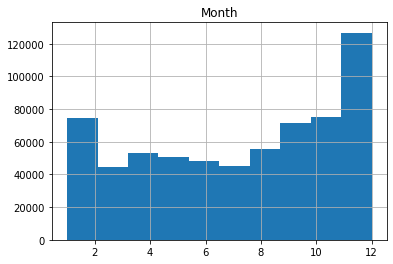

In [89]:
#Monthly trend of whole dataset
wholeDataSet1=wholeDataSet.copy()
wholeDataSet1['Month'] = wholeDataSet1['Month'].astype(int)
wholeDataSet1.hist(column='Month')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b07512bd0>]],
      dtype=object)

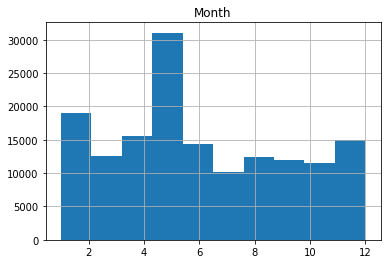

In [88]:
#Monthly trend of cluster 0
histcluster0=cluster0.copy()
histcluster0['Month'] = histcluster0['Month'].astype(int)
histcluster0.hist(column='Month')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b07801e10>]],
      dtype=object)

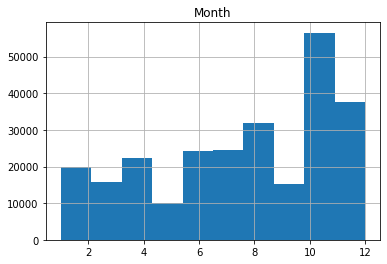

In [90]:
#Monthly trend of cluster 1
histcluster1=cluster1.copy()
histcluster1['Month'] = histcluster1['Month'].astype(int)
histcluster1.hist(column='Month')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b090f8bd0>]],
      dtype=object)

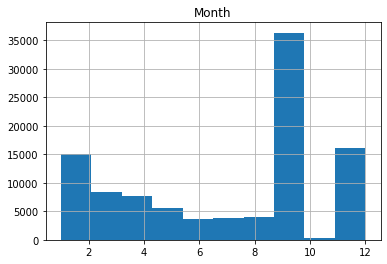

In [91]:
#Monthly trend of cluster 2
histcluster2=cluster2.copy()
histcluster2['Month'] = histcluster2['Month'].astype(int)
histcluster2.hist(column='Month')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c605e6e50>]],
      dtype=object)

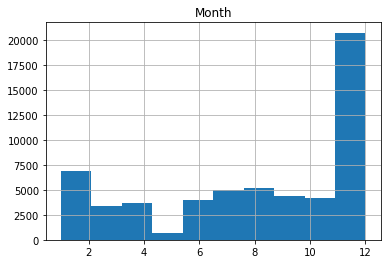

In [92]:
#Monthly trend of cluster 3
histcluster3=cluster3.copy()
histcluster3['Month'] = histcluster3['Month'].astype(int)
histcluster3.hist(column='Month')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b07e56a10>]],
      dtype=object)

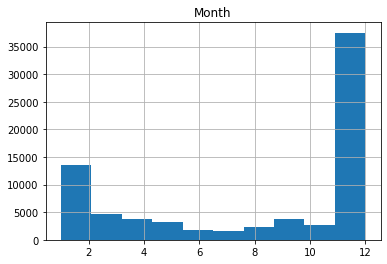

In [94]:
#Monthly trend of cluster 4
histcluster4=cluster4.copy()
histcluster4['Month'] = histcluster4['Month'].astype(int)
histcluster4.hist(column='Month')